In [1]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
np.random.seed(0)

In [3]:
os.chdir("../../data")

In [4]:
recommendee = "mpfei"

In [5]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [6]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [7]:
# add additional user anime-lists
extraUsers = pickle.load(open("user_profiles/ExtraUserAnimeLists.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(extraUsers.username)]
filtered_df = pd.concat([filtered_df, extraUsers], ignore_index=True)

In [8]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [9]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [10]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [11]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on="anime_id")
    adj_cos_corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["normalized_score_x"], x["normalized_score_y"])
    )
    adj_cos_corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["normalized_score"], x["normalized_score"]))
    )
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame(
        (adj_cos_corr_numerator / adj_cos_corr_denom), columns=["corr"]
    )
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [12]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [13]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960563,-0.059899,0.605474,0.605474
karthiga,59,7,0.040202,-0.059899,-0.474165,-0.474165
karthiga,74,7,0.316282,-0.059899,-0.750244,-0.750244
karthiga,120,7,0.309858,-0.059899,-0.743820,-0.743820
karthiga,178,7,-0.227339,-0.059899,-0.206623,-0.206623


In [14]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, normalize_variance
):

    # Should we normalize by variance?
    # Note that normalize_variance=True modifies the data
    if normalize_variance:
        user_stds = (
            is_df.groupby("username")[["normalized_score"]]
            .std()
            .rename({"normalized_score": "user_std"}, axis=1)
        )
        is_df = is_df.merge(user_stds, on="username")
        is_df["normalized_score"] /= is_df["user_std"]
        is_df = is_df.drop("user_std", axis=1)

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.sort_values(by="similarity").dropna()
    corrs = corrs.drop(recommendee)  # makes insample score more meaningful

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (
            is_df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on="username")
        ).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "normalize_variance": normalize_variance,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [15]:
%%time
from tqdm import tqdm

K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(len(filtered_df)) / np.log(base)) + 1)
] + [len(filtered_df)]
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), recommendee, neighborhood_sizes, False
        )
    )

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,6114,7,0.962501,0.533536,-1.989899,-1.989899
mpfei,82,8,0.281788,0.533536,-0.309185,-0.309185
mpfei,14813,9,0.507706,0.533536,0.464897,0.464897
mpfei,7311,9,1.350428,0.533536,-0.377825,-0.377825
mpfei,30276,9,1.149011,0.533536,-0.176408,-0.176408


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,32182,9,0.864817,0.533536,0.107785,0.107785
mpfei,268,8,0.494845,0.533536,-0.522242,-0.522242
mpfei,4382,9,-0.352282,0.533536,1.324884,1.324884
mpfei,24781,5,0.024080,0.533536,-3.051478,-3.051478
mpfei,18679,9,0.598908,0.533536,0.373695,0.373695


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,29803,5,0.417982,0.533536,-3.445379,-3.445379
mpfei,37999,9,1.506139,0.533536,-0.533536,-0.533536
mpfei,25519,8,-0.129936,0.533536,0.102539,0.102539
mpfei,13125,8,0.870968,0.533536,-0.898365,-0.898365
mpfei,245,8,1.187125,0.533536,-1.214522,-1.214522


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,21405,9,0.311698,0.533536,0.660905,0.660905
mpfei,12467,9,-0.268197,0.533536,1.240800,1.240800
mpfei,14397,7,1.051411,0.533536,-2.078808,-2.078808
mpfei,38659,8,0.506139,0.533536,-0.533536,-0.533536
mpfei,10087,7,1.009724,0.533536,-2.037121,-2.037121


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,30,8,0.724363,0.533536,-0.751761,-0.751761
mpfei,34152,8,-0.292988,0.533536,0.265590,0.265590
mpfei,849,9,0.589172,0.533536,0.383431,0.383431
mpfei,31240,7,0.816733,0.533536,-1.844131,-1.844131
mpfei,5040,8,0.874075,0.533536,-0.901473,-0.901473


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,31646,9,0.753426,0.533536,0.219177,0.219177
mpfei,1689,7,0.556230,0.533536,-1.583627,-1.583627
mpfei,1292,7,-0.291580,0.533536,-0.735817,-0.735817
mpfei,9756,9,0.981338,0.533536,-0.008736,-0.008736
mpfei,30831,9,0.499314,0.533536,0.473289,0.473289


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,7785,8,0.958918,0.533536,-0.986315,-0.986315
mpfei,721,8,0.625253,0.533536,-0.652650,-0.652650
mpfei,2001,7,1.194917,0.533536,-2.222315,-2.222315
mpfei,227,8,0.368341,0.533536,-0.395739,-0.395739
mpfei,2251,8,1.007394,0.533536,-1.034791,-1.034791


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,339,8,0.347777,0.533536,-0.375174,-0.375174
mpfei,1575,8,1.240077,0.533536,-1.267474,-1.267474
mpfei,22199,7,0.026090,0.533536,-1.053487,-1.053487
mpfei,32937,9,0.719981,0.533536,0.252622,0.252622
mpfei,2904,8,1.415048,0.533536,-1.442446,-1.442446


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,16664,10,0.760659,0.533536,1.211944,1.211944
mpfei,35180,9,1.478083,0.533536,-0.505481,-0.505481
mpfei,34933,6,-0.132314,0.533536,-1.895083,-1.895083
mpfei,10800,8,0.813220,0.533536,-0.840617,-0.840617
mpfei,31764,7,0.235000,0.533536,-1.262397,-1.262397


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,11981,9,0.942518,0.533536,0.030084,0.030084
mpfei,486,8,0.890540,0.533536,-0.917937,-0.917937
mpfei,38826,8,0.506139,0.533536,-0.533536,-0.533536
mpfei,39195,9,1.006139,0.533536,-0.033536,-0.033536
mpfei,32979,9,0.100344,0.533536,0.872259,0.872259


100%|██████████| 10/10 [2:58:49<00:00, 1072.96s/it] 

CPU times: user 2h 47min 58s, sys: 38min, total: 3h 25min 59s
Wall time: 2h 58min 51s


In [16]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [17]:
allerrors

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
0,0.015385,1.189886,1.0,0.0,0.0,0.784349
1,0.015385,1.189886,1.0,0.0,0.0,0.784349
2,0.015385,1.189886,2.0,0.0,0.0,0.784349
3,0.015385,1.189886,2.0,0.0,0.0,0.784349
4,0.030769,1.150500,4.0,0.0,0.0,0.784349
...,...,...,...,...,...,...
515,0.969697,0.721456,11863283.0,0.0,1.0,1.235771
516,0.969697,0.721456,16777216.0,0.0,1.0,1.235771
517,0.969697,0.721456,23726566.0,0.0,1.0,1.235771
518,0.969697,0.721456,33554432.0,0.0,1.0,1.235771


In [18]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "normalize_variance"])

In [19]:
wide_data.loc[lambda x: x.normalize_variance == True, "variable"] = (
    "normalized_" + wide_data.loc[lambda x: x.normalize_variance == True, "variable"]
)

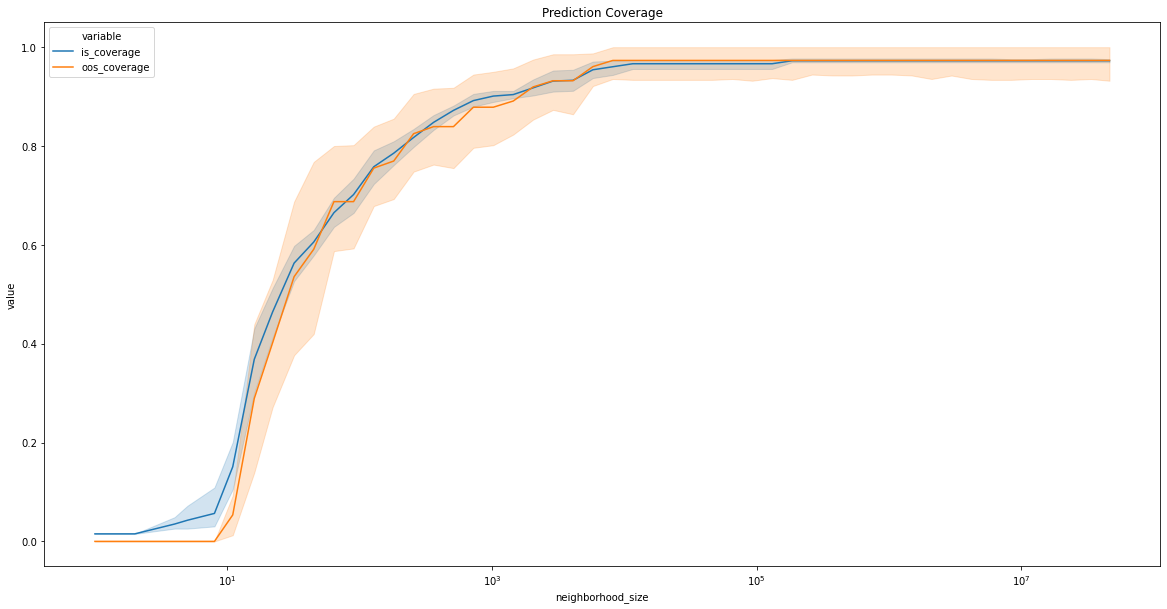

In [20]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

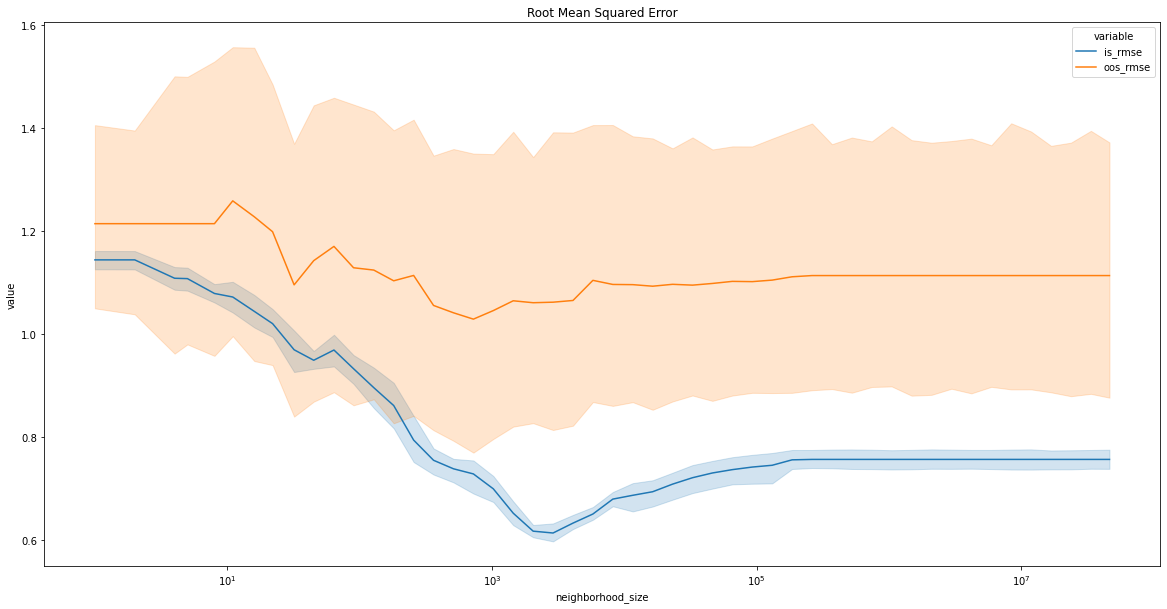

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [22]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
normalize_variance neighborhood_size                                               
0.0                724.0                 0.891958  0.728083      0.878571  1.028656
                   512.0                 0.872145  0.738025      0.839286  1.040997
                   1024.0                0.901096  0.699132      0.878571  1.045262
                   362.0                 0.847879  0.754553      0.839286  1.055252
                   2048.0                0.917762  0.616894      0.919643  1.060543
                   2896.0                0.931492  0.613333      0.932143  1.061575
                   1448.0                0.904126  0.651821      0.891071  1.064297
                   4096.0                0.933007  0.632542      0.932143  1.064907
                   16384.0               0.966550  0.693482      0.973214  1.092621
                   32768.0               0.966550  0.720700      0.973214  1.094684

In [23]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(
    0, level="normalize_variance"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
724.0,0.891958,0.728083,0.878571,1.028656
512.0,0.872145,0.738025,0.839286,1.040997
1024.0,0.901096,0.699132,0.878571,1.045262
362.0,0.847879,0.754553,0.839286,1.055252
2048.0,0.917762,0.616894,0.919643,1.060543
2896.0,0.931492,0.613333,0.932143,1.061575
1448.0,0.904126,0.651821,0.891071,1.064297
4096.0,0.933007,0.632542,0.932143,1.064907
16384.0,0.966550,0.693482,0.973214,1.092621


In [24]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(
    0, level="normalize_variance"
).sort_values(by="is_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
2896.0,0.931492,0.613333,0.932143,1.061575
2048.0,0.917762,0.616894,0.919643,1.060543
4096.0,0.933007,0.632542,0.932143,1.064907
5792.0,0.954336,0.650211,0.960714,1.103992
1448.0,0.904126,0.651821,0.891071,1.064297
8192.0,0.960490,0.679157,0.973214,1.096029
11585.0,0.966550,0.686562,0.973214,1.095637
16384.0,0.966550,0.693482,0.973214,1.092621
1024.0,0.901096,0.699132,0.878571,1.045262


In [25]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["normalize_variance", "neighborhood_size"]).mean().xs(
    0, level="normalize_variance"
)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
1.0,0.015221,1.143760,0.000000,1.214050
2.0,0.015221,1.143760,0.000000,1.214050
4.0,0.035082,1.108059,0.000000,1.214050
5.0,0.042774,1.107346,0.000000,1.214050
8.0,0.056597,1.078516,0.000000,1.214050
11.0,0.150979,1.071634,0.053571,1.258368
16.0,0.368485,1.043770,0.289286,1.227471
22.0,0.464149,1.019943,0.401786,1.198420
32.0,0.563170,0.969172,0.535714,1.095240


In [26]:
allerrors.groupby(["normalize_variance", "neighborhood_size"]).apply(
    lambda x: np.sqrt(np.sum(x ** 2) / K)
).xs(0, level="normalize_variance")

,is_coverage,is_rmse,neighborhood_size,normalize_variance,oos_coverage,oos_rmse
neighborhood_size,,,,,,
1.0,0.021527,1.618584,1.414214e+00,0.0,0.000000,1.828147
2.0,0.021527,1.618584,2.828427e+00,0.0,0.000000,1.828147
4.0,0.040191,1.108607,4.000000e+00,0.0,0.000000,1.292695
5.0,0.060226,1.107933,5.000000e+00,0.0,0.000000,1.292695
8.0,0.096832,1.078901,8.000000e+00,0.0,0.000000,1.292695
11.0,0.168373,1.072698,1.100000e+01,0.0,0.084892,1.340864
16.0,0.381943,1.045056,1.600000e+01,0.0,0.373381,1.314908
22.0,0.470985,1.020933,2.200000e+01,0.0,0.456424,1.281701
32.0,0.566040,0.971128,3.200000e+01,0.0,0.593061,1.184897
